In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd
import scipy.stats as stats

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers
from keras.optimizers import Adam
import random
from time import time
from imblearn.over_sampling import SMOTE

# plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  # visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Thesis/Final_Real.csv', index_col=0)

In [ ]:
# Splitting the dataset
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [ ]:
# Rescale the features

scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                                     index=X_train.index,
                                     columns=X_train.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((164563, 6), (70527, 6))

In [ ]:
def get_hyper_param(n_iteration):
  hyper_param = []  # timestep, units, epochs, batch_size
  for i in range(n_iteration):
    current_params = []
    current_params.append(np.random.randint(10, 100)) # timestep
    current_params.append(np.random.randint(10, 50)) # number of hidden units
    current_params.append(np.random.randint(1, 20)) # number of epochs
    current_params.append(np.random.randint(10, 100)) # batch size
    hyper_param.append(current_params)
  return hyper_param
  
hyper_parameter = get_hyper_param(10)

In [ ]:
train_loss, val_loss = list(), list()
best_params = []
def fit_gru_random(batch_size):
  min_val_loss = 999
  for timestep, units, epochs, batch_size in hyper_parameter:
    print('Window size',timestep, 'units', units, 'epochs', epochs,'batch_size', batch_size)
    T = timestep  # timesteps window
   
    # Transforming data into 3D shape
    X_train_1, y_train_1 = [], []
    for i in range(y_train.shape[0] - (T-1)):
        X_train_1.append(train_scaled.iloc[i:i+T].values)
        y_train_1.append(y_train.iloc[i + (T-1)])
    X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
    print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

    X_test_1, y_test_1 = [], []
    for i in range(y_test.shape[0] - (T-1)):
        X_test_1.append(test_scaled.iloc[i:i+T].values)
        y_test_1.append(y_test.iloc[i + (T-1)])
    X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  

    print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

  # defining the GRU model
  
    model = Sequential()
    model.add(GRU(units, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
    model.add(GRU(units, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])   
    print(model.summary())

    # Define a learning rate decay method:
    lr_decay = ReduceLROnPlateau(monitor='loss', 
                              patience=1, verbose=1, 
                              factor=0.5, min_lr=1e-8)
    # Define Early Stopping:
    early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                            patience=30, verbose=1, mode='auto',
                            baseline=0, restore_best_weights=True)

    # fit model
    start = time()
    history = model.fit(X_train_1, y_train_1,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data=(X_test_1, y_test_1),
                      shuffle=True,verbose=1,
                      callbacks=[early_stop])
    current_val_loss = history.history['val_loss'][-1]
    
    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params = [timestep, units, epochs, batch_size]
      print('best_params',best_params)
    
  print('final best params',best_params)
  return best_params

In [ ]:
train_loss, val_loss = [], []
repeats = 1
def run_gru_random():
  n_batch = 10
  history = fit_gru_random(n_batch)

In [ ]:
run_gru_random()

Window size 16 units 30 epochs 9 batch_size 48
Train data dimensions: (164548, 16, 6), (164548, 1)
Test data dimensions: (70512, 16, 6), (70512, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 16, 30)            3420      
                                                                 
 gru_3 (GRU)                 (None, 30)                5580      
                                                                 
 dense_1 (Dense)             (None, 9)                 279       
                                                                 
Total params: 9,279
Trainable params: 9,279
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/9
3429/3429 [==============================] - 62s 17ms/step - loss: 0.2619 - accuracy: 0.9229 - val_loss: 0.1606 - val_accuracy: 0.9468
Epoch 2/9
3429/342

In [ ]:
best_timestep = 23
best_num_units = 40
best_epochs = 16
best_batch_size = 24  

In [ ]:
# Without SMOTE
# Rescale the features

scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                                     index=X_train.index,
                                     columns=X_train.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((164563, 6), (70527, 6))

In [ ]:
T = best_timestep
X_train_1, y_train_1 = [], []
for i in range(y_train.shape[0] - (T-1)):
  X_train_1.append(train_scaled.iloc[i:i+T].values)
  y_train_1.append(y_train.iloc[i + (T-1)])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

X_test_1, y_test_1 = [], []
for i in range(y_test.shape[0] - (T-1)):
  X_test_1.append(test_scaled.iloc[i:i+T].values)
  y_test_1.append(y_test.iloc[i + (T-1)])
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  
print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

Train data dimensions: (164541, 23, 6), (164541, 1)
Test data dimensions: (70505, 23, 6), (70505, 1)


In [ ]:
# GRU model with 2 stucked LSTM layers with activation function relu

model = Sequential()
model.add(GRU(best_num_units, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(best_num_units, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                                patience=1, verbose=1, 
                                factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                              patience=30, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                        epochs=best_epochs,
                        batch_size=best_batch_size,
                        validation_data=(X_test_1, y_test_1),
                        shuffle=True,verbose=1,
                        callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

y_pred = np.argmax(model.predict(X_test_1), axis=-1)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 23, 40)            5760      
                                                                 
 gru_29 (GRU)                (None, 40)                9840      
                                                                 
 dense_16 (Dense)            (None, 9)                 369       
                                                                 
Total params: 15,969
Trainable params: 15,969
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/16
6856/6856 [==============================] - 171s 23ms/step - loss: 0.1959 - accuracy: 0.9371 - val_loss: 0.1313 - val_accuracy: 0.9496 - lr: 0.0010
Epoch 2/16
6856/6856 [==============================] - 153s 22ms/step - loss: 0.1062 - accuracy: 0.9583 - val_loss: 0.0952 - val_accuracy: 0.9620 -

<Axes: >

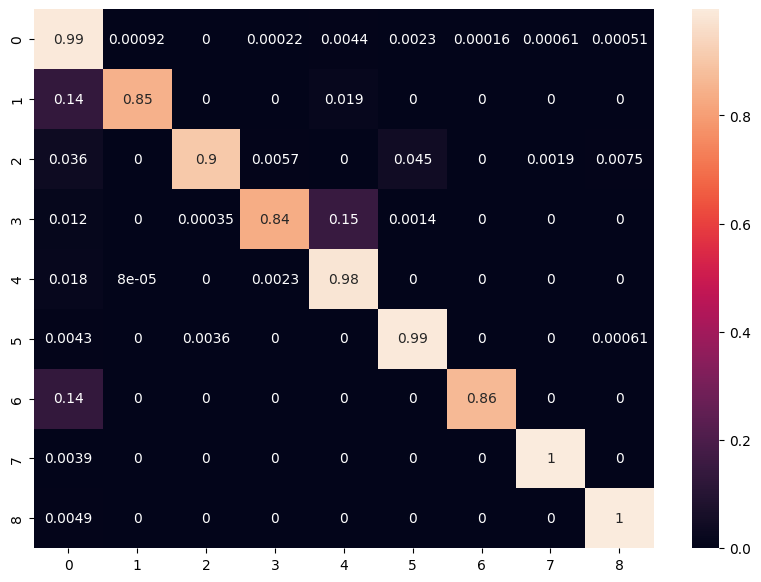

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

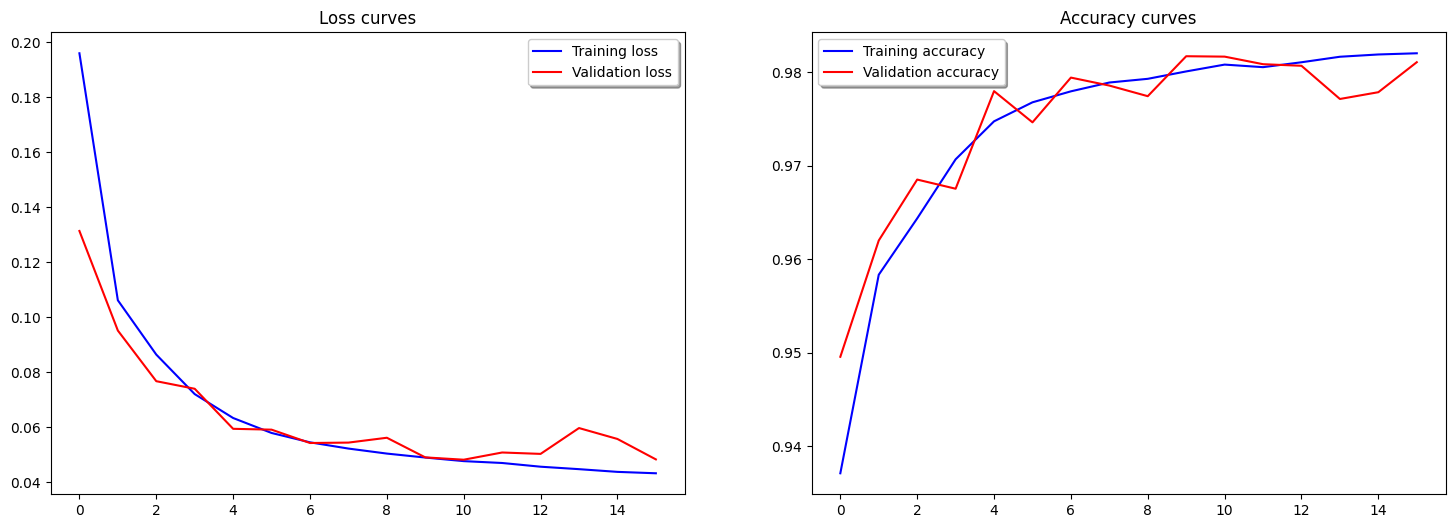

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9810509892915396
Confusion Matrix: 
 [[50353    47     0    11   222   118     8    31    26]
 [   57   355     0     0     8     0     0     0     0]
 [   19     0   479     3     0    24     0     1     4]
 [   35     0     1  2387   428     4     0     0     0]
 [  225     1     0    29 12185     0     0     0     0]
 [    7     0     6     0     0  1630     0     0     1]
 [   13     0     0     0     0     0    83     0     0]
 [    5     0     0     0     0     0     0  1288     0]
 [    2     0     0     0     0     0     0     0   409]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     50816
           1       0.88      0.85      0.86       420
           2       0.99      0.90      0.94       530
           3       0.98      0.84      0.90      2855
           4       0.95      0.98      0.96     12440
           5       0.92      0.99      0.95      1644
           6